## **Shielf Insurance Premium Predictor**

**Import Required Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### **Data Cleaning & EDA - Part 1**

**Explore Dataset**

In [4]:
df = pd.read_excel("premiums.xlsx")
print(df.shape)
df.head(4)

(50000, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303


In [5]:
df['Age'].dtypes

dtype('int64')

In [6]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

**Normalize Column Titles**

In [7]:
df.columns.str.replace(' ','_')

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number_Of_Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical_History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [8]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [9]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

### **Handle NAN Values**

In [10]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [11]:
# Since null values are very few compared to dataset, we can just drop them
df.dropna(inplace=True)
df.isnull().sum()
df.shape

(49976, 13)

**Check & Handle Duplicates**

In [12]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [13]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


**Let's Treat Negative Values in Number of Dependants**

In [14]:
df[df['number_of_dependants']<0].shape

(72, 13)

In [15]:
df[df['number_of_dependants']<0].number_of_dependants.unique()

# It seems the negative values might have been due to typo, so we can apply absolute function

array([-3, -1], dtype=int64)

In [16]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [17]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


**Check Distribution of Numerical Features**

In [18]:
# This is how to fetch all numeric columns in your dataset

df.select_dtypes(['float64', 'int64'])

,age,number_of_dependants,income_lakhs,annual_premium_amount
0,26,0,6,9053
1,29,2,6,16339
2,49,2,20,18164
3,30,3,77,20303
4,18,0,99,13365
...,...,...,...,...
49995,24,0,35,9111
49996,47,2,82,27076
49997,21,0,32,8564
49998,18,2,20,9490


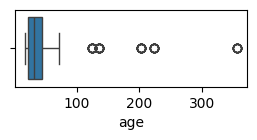

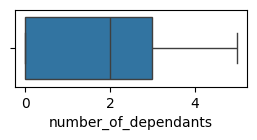

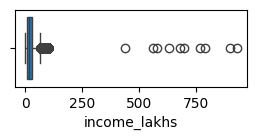

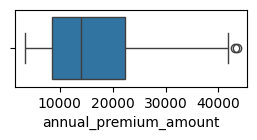

In [19]:
numerical_features = df.select_dtypes(['float64', 'int64']).columns

for feature in numerical_features:
    plt.figure(figsize=(3,1))
    sns.boxplot(x = df[feature])
    

**Treat Outliers in Age Using Threshold (max_Age=100)**

In [20]:
df[df.age>100].age.unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [21]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


**Treat Outliers in Income Using IQR**

<Axes: >

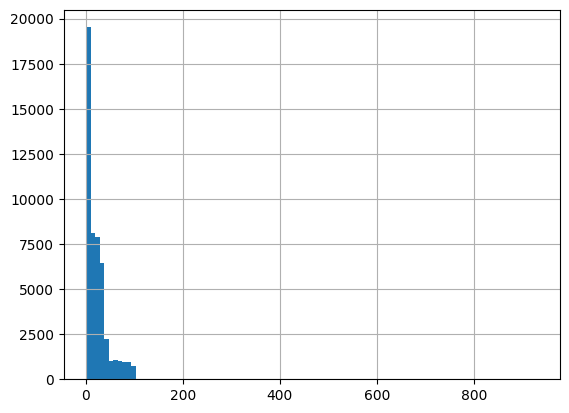

In [22]:
df1['income_lakhs'].hist(bins=100)

In [23]:
df1['income_lakhs'].quantile([0.25,0.75])


0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [24]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [25]:
get_iqr_bounds(df1.income_lakhs)

# we won't worry on the lower_bound rather on the upper bound, 67, which is not that extreme

(-29.0, 67.0)

In [26]:
# Rather we can choose to set a threshold

quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold

100.0

In [27]:
df1[df1['income_lakhs']>quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
2635,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692
4220,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636
7775,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010
9021,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848
10337,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945
10639,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888
11456,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424
15437,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586
35446,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115
40970,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926


In [28]:
# Since just a total of 10 people has income above the set threshold, we can then decide to drop them

df2 = df1[df1['income_lakhs']<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


#### **Data Cleaning & EDA - Part 2**

**View Numerical Data on Histogram: Univariate Analysis**

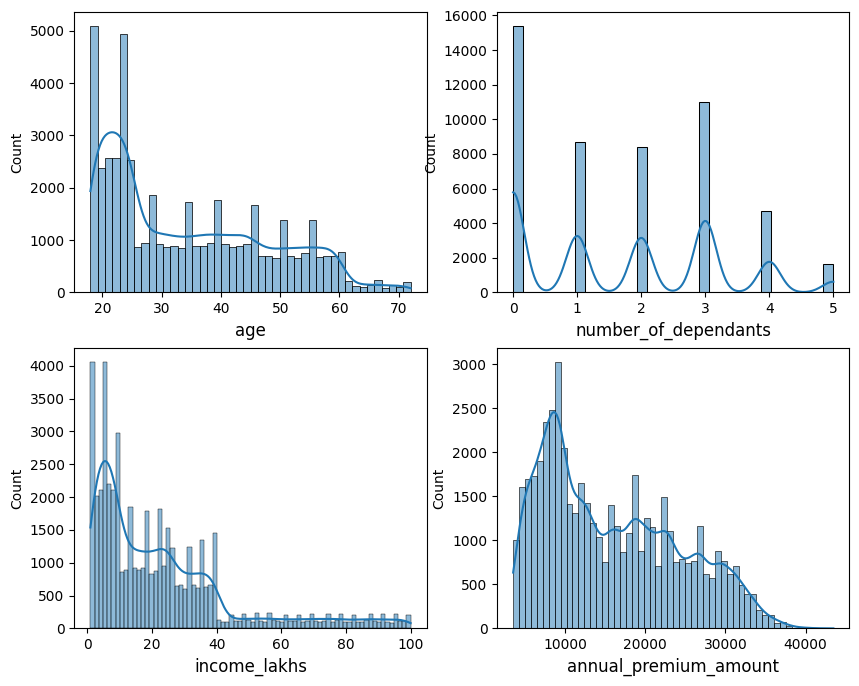

In [29]:
numerical_features = df2.select_dtypes(['float64', 'int64']).columns

n = numerical_features.shape[0]

fig, axes = plt.subplots(int(n/2),2,figsize=(10,8))
axes = axes.flatten()

for i,feature in enumerate(numerical_features):
    sns.histplot(data = df2, x = feature, kde=True, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=12)

plt.show()

**Bivariate Analysis of Numerical Features w.r.t annual_premium_income**

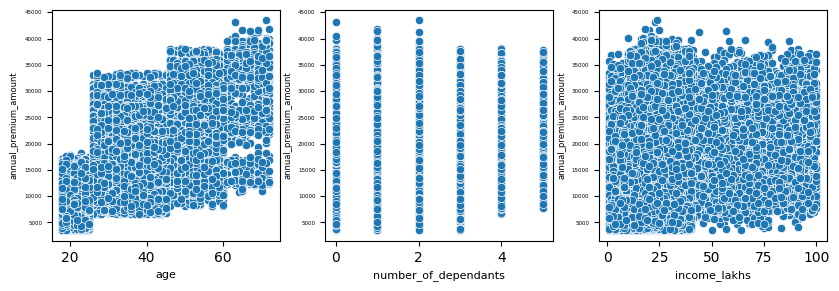

In [30]:
numerical_features = df2.select_dtypes(['float64', 'int64']).columns
bivariate_features = numerical_features.drop('annual_premium_amount')


fig, axes = plt.subplots(1,3,figsize=(10,3))
axes = axes.flatten()

for i,feature in enumerate(bivariate_features):
    sns.scatterplot(data = df2, x=feature, y='annual_premium_amount', ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=8)
    axes[i].set_ylabel('annual_premium_amount', fontsize=6)
    axes[i].tick_params(axis='y', labelsize=4)
for j in range(len(bivariate_features), len(axes)):
    fig.delaxes(axes[j])

plt.show()


**Categorical Columns EDA**

In [31]:
categorical_features = df2.select_dtypes(['object']).columns
categorical_features
for col in categorical_features:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [32]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [33]:
get_count = df2.gender.value_counts(normalize=True)*100
get_count

gender
Male      54.963132
Female    45.036868
Name: proportion, dtype: float64

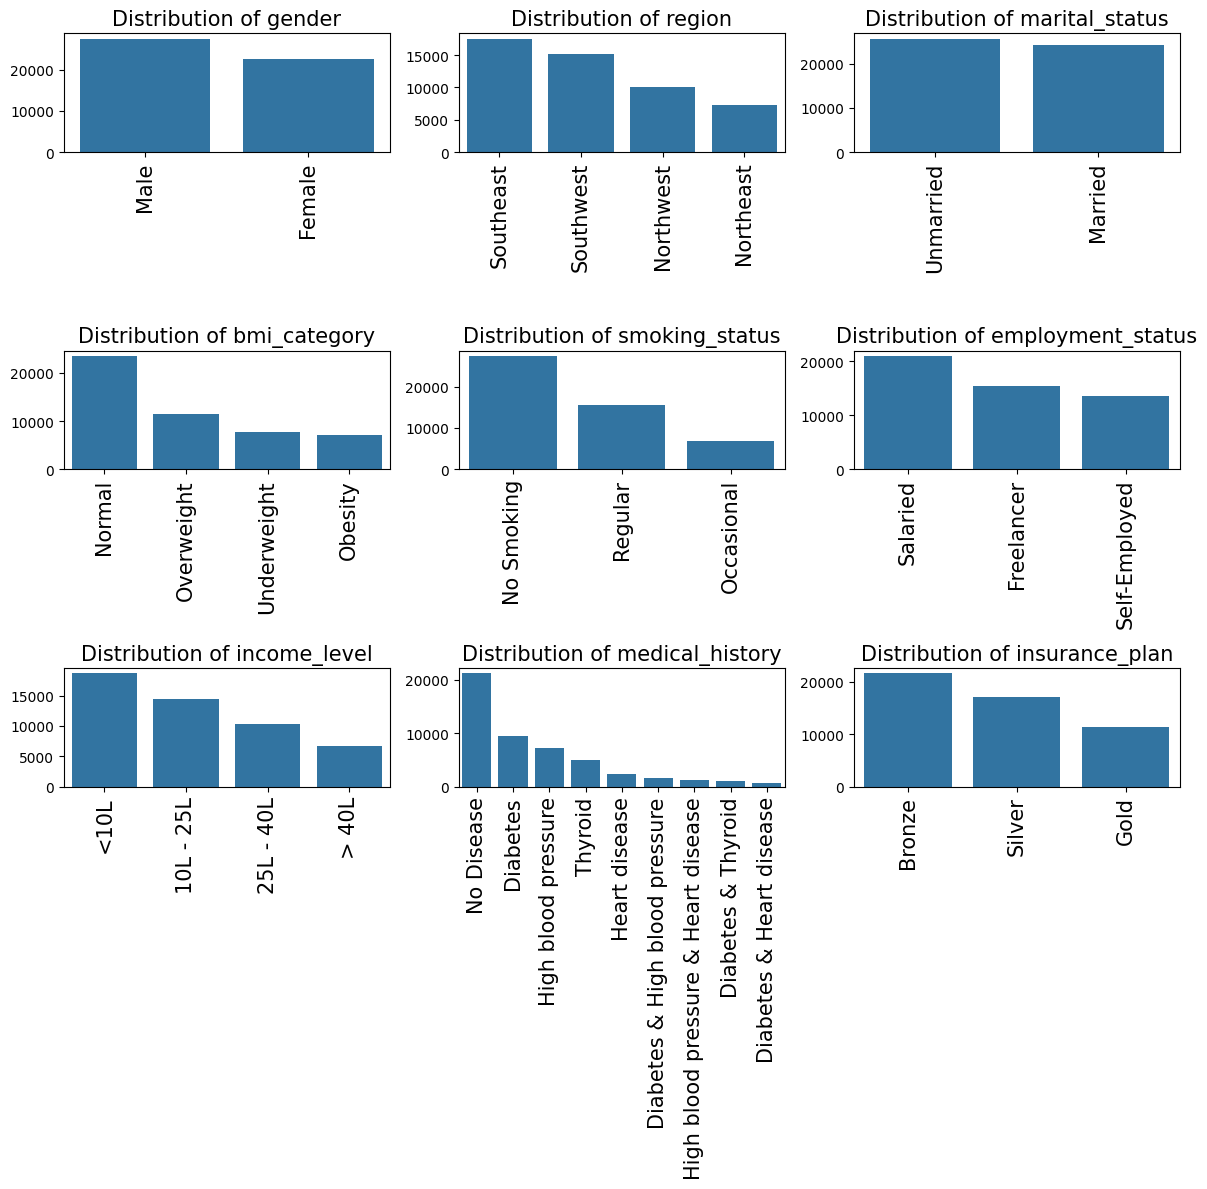

In [34]:
import math
categorical_features = df2.select_dtypes(['object']).columns
n = len(categorical_features)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(12,12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    get_count = df2[col].value_counts()
    sns.barplot(x=get_count.index, y=get_count.values, ax = axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=15)
    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



**Crosstab ::: Cross Tabulation**

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


<Axes: xlabel='income_level'>

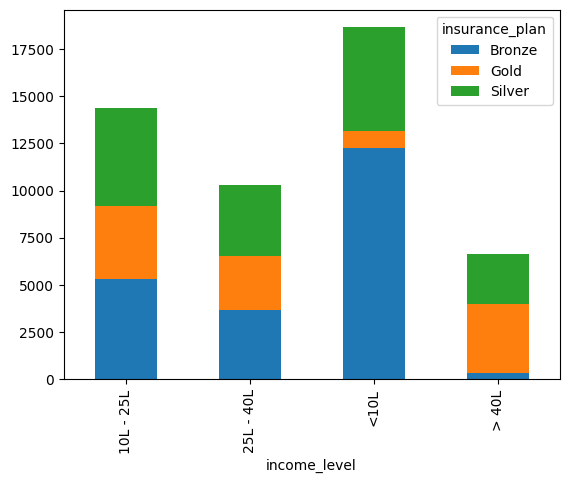

In [35]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)

<Axes: xlabel='insurance_plan', ylabel='income_level'>

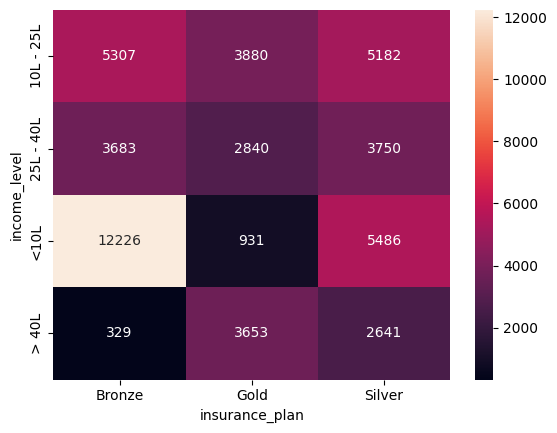

In [36]:
sns.heatmap(crosstab,fmt='d', annot=True)

#### **Feature Engineering: Converting Text to Numbers**

In [37]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [38]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

**Normalizing medical_history column**

In [39]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [40]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split('&', expand=True).apply(lambda x: x.str.strip().str.lower())
df2.head(4)




,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None


In [41]:
df2.isnull().sum()

age                          0
gender                       0
region                       0
marital_status               0
number_of_dependants         0
bmi_category                 0
smoking_status               0
employment_status            0
income_level                 0
income_lakhs                 0
medical_history              0
insurance_plan               0
annual_premium_amount        0
disease1                     0
disease2                 45140
dtype: int64

In [42]:
df2[df2['disease2'].isnull()].shape

(45140, 15)

In [43]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)



In [44]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
total_risk_score         0
dtype: int64

**Scale Total Risk Score with MinMaxScaler Approach**

In [45]:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000


**Normalizing insurance_plan column**

In [46]:
df2.insurance_plan.unique()

# # It's more like an ordinal categorical variable

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [47]:
df2['insurance_plan'] = df2.insurance_plan.map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,no disease,none,0,0.000000


In [48]:
# df2[df2['normalized_risk_score'].isnull()]

**Normalizing income_level column**

In [49]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [50]:
df2['income_level'] = df2.income_level.map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})

In [51]:
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000


**Normalizing Nominal columns: One Hot Encoding**

In [52]:
nominal_cols = ['gender',	'region',	'marital_status','bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first = True, dtype=int)
df3.head(4)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0


In [53]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)

In [54]:
df4.isnull().sum()

age                                0
number_of_dependants               0
income_level                       0
income_lakhs                       0
insurance_plan                     0
annual_premium_amount              0
normalized_risk_score              0
gender_Male                        0
region_Northwest                   0
region_Southeast                   0
region_Southwest                   0
marital_status_Unmarried           0
bmi_category_Obesity               0
bmi_category_Overweight            0
bmi_category_Underweight           0
smoking_status_Occasional          0
smoking_status_Regular             0
employment_status_Salaried         0
employment_status_Self-Employed    0
dtype: int64

**Feature Selection: Correlation and VIF**

**Correlation**

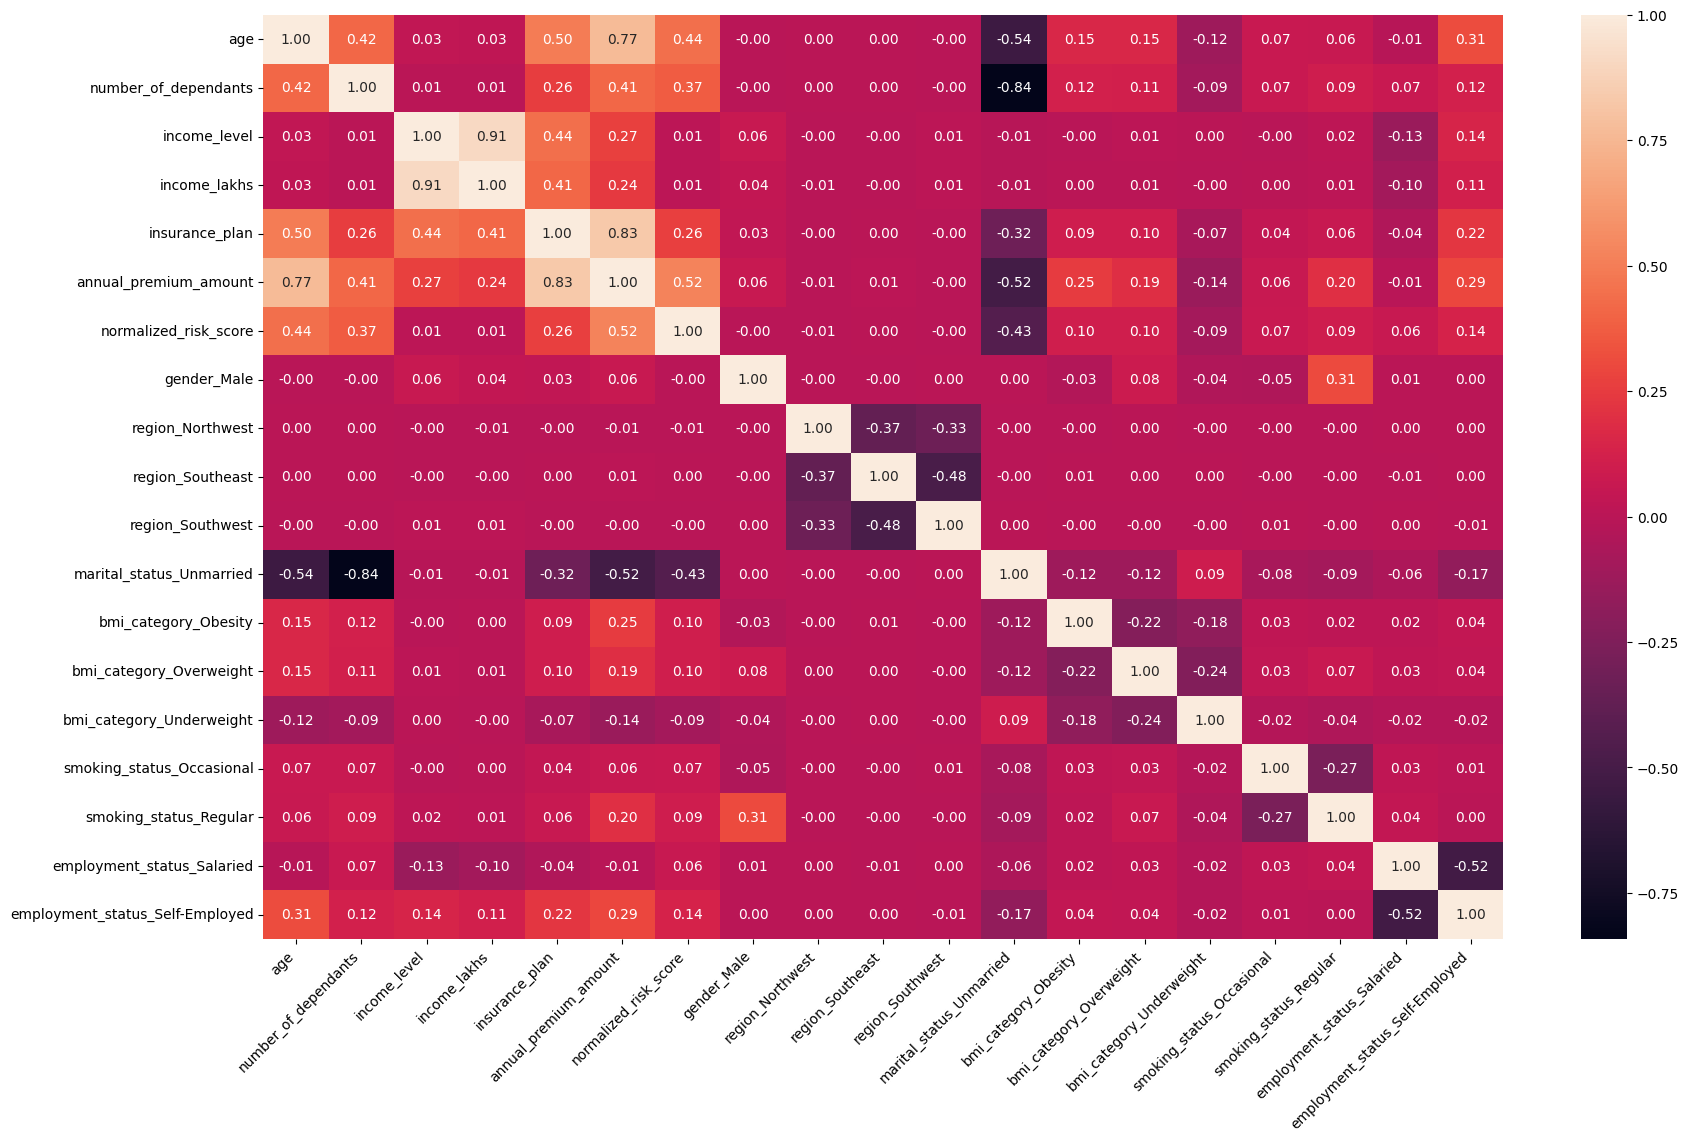

In [55]:
cm = df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm, fmt='.2f', annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**VIF - Process**

In [56]:
df4.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0


In [57]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','income_lakhs', 'number_of_dependants' ,'income_level', 'insurance_plan']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0


In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [59]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [60]:
# Due to high Correlation between income_level & income_lakhs, 
# We drop the feature with the highest value; income_level

calculate_vif(X.drop('income_level', axis='columns'))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [61]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head(4)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0


### **Model Training**

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (34935, 17)
X_test:  (14973, 17)
y_train:  (34935,)
y_test:  (14973,)


**Train Linear Regression**

In [63]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

# Doing a train_score is to check the performance of both train and test dataset.
# When tran_set is overfitting, the score will be higher than test_set.
# There's no overfitting.

(0.9282143576916762, 0.9280547230217837)

In [64]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3598,0.481481,0.4,0.343434,0.5,0.428571,1,0,1,0,1,0,1,0,0,1,1,0


In [65]:
model_lr.intercept_

4824.300272127091

In [66]:
 model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

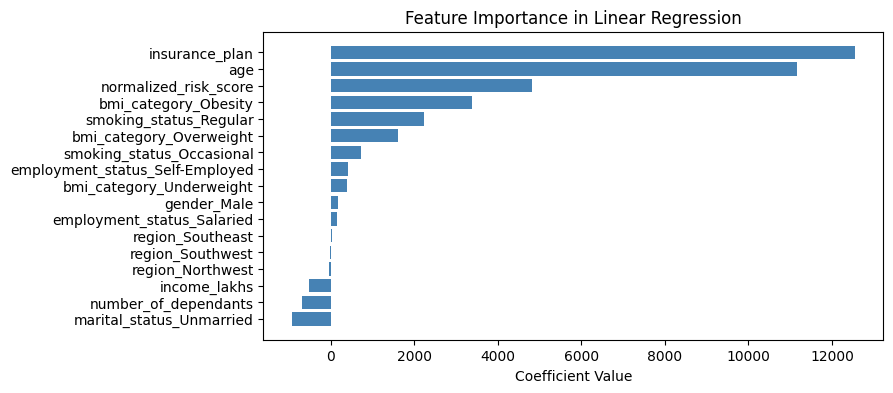

In [67]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df_sorted = coef_df.sort_values(by='Coefficients',ascending=True)
coef_df_sorted

plt.figure(figsize=(8,4))
plt.barh(coef_df_sorted.index, coef_df_sorted['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [68]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

In [69]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9860964164832711, 0.9809534637207582)

**Applying RandomSearchCV for Best Hyperparameter to Fine Tune Model**

In [70]:
model_xgb = XGBRegressor()
params_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5,10,15]
}

random_search = RandomizedSearchCV(model_xgb, params_grid, n_iter=10, cv=3, scoring='r2', random_state=10)
random_search.fit(X_train, y_train)
print(random_search.best_params_)
random_search.best_score_


{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


0.9809474553641963

In [71]:
best_model = random_search.best_estimator_

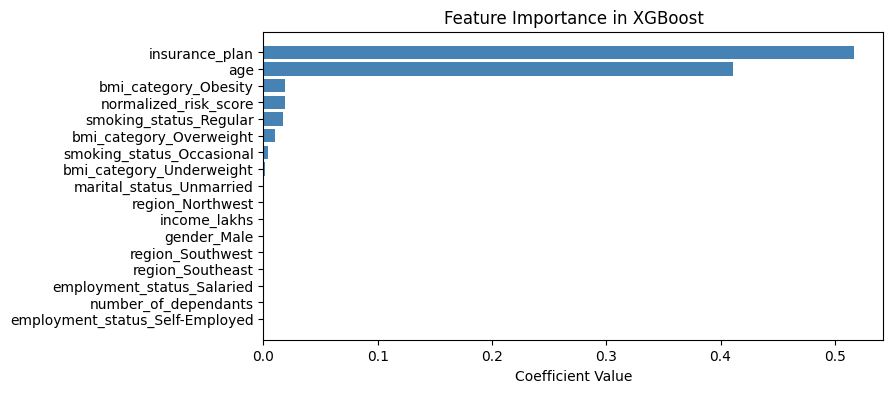

In [72]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df_sorted = coef_df.sort_values(by='Coefficients',ascending=True)
coef_df_sorted

plt.figure(figsize=(8,4))
plt.barh(coef_df_sorted.index, coef_df_sorted['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### **Error Analysis**

In [73]:
# Let's check the level of error margin between the y_test and y_pred
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
results_df.head(4)

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087


<Axes: xlabel='diff_pct', ylabel='Count'>

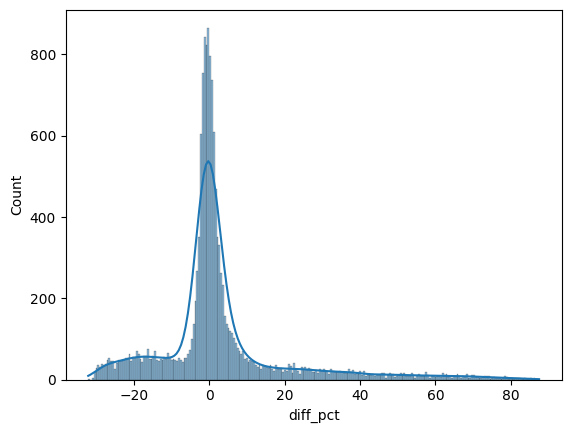

In [74]:
# It will be useful to see the distribution of the margin
sns.histplot(results_df['diff_pct'], kde=True)

In [75]:
# Having an error margin as high as 80% is not a good one

extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df

,actual,predicted,diff,diff_pct
42730,5018,7352.829590,2334.829590,46.529087
20029,5140,6670.849121,1530.849121,29.783057
4294,9631,7053.477539,-2577.522461,-26.762771
44419,4687,6670.849121,1983.849121,42.326629
6707,8826,10047.326172,1221.326172,13.837822
...,...,...,...,...
8767,8113,6565.852051,-1547.147949,-19.069986
25179,9944,7058.687988,-2885.312012,-29.015608
21592,8332,10615.658203,2283.658203,27.408284
49274,5571,6820.886230,1249.886230,22.435581


In [76]:
results_df.shape

(14973, 4)

In [77]:
# Percentage of predictions with %_error above 10%
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.967274427302478

In [80]:
# Let's check further on those with high error margin, say >50
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

# The highest error is 87.5%, this is not good.

# We need to do further analysis to know what's responsible for the high margin errors

,actual,predicted,diff,diff_pct
36269,3501,6565.852051,3064.852051,87.542189
48801,3516,6565.852051,3049.852051,86.742095
42342,3521,6565.852051,3044.852051,86.476911
18564,3523,6565.852051,3042.852051,86.371049
7988,3527,6565.852051,3038.852051,86.159684
...,...,...,...,...
32671,4656,6994.980957,2338.980957,50.235845
14798,4371,6565.852051,2194.852051,50.213957
13736,4371,6565.852051,2194.852051,50.213957
10107,4710,7073.240723,2363.240723,50.174962


In [81]:
X_test.index

Index([ 3598, 35794, 43608, 42730, 18936, 45416, 20029,  4294, 39145,  3152,
       ...
        4554,  9086,  8767,   603, 25179,  5621,  6069, 21592, 49274, 27977],
      dtype='int64', length=14973)

In [82]:
extreme_results_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [83]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


**Tracing the Root-Cause of High Error: Compare X_test & Error Distributions**

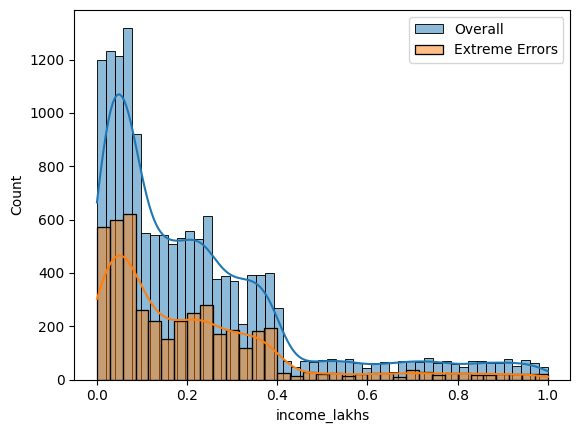

In [86]:
sns.histplot(X_test.income_lakhs, label='Overall', kde=True)
sns.histplot(extreme_errors_df.income_lakhs, label='Extreme Errors', kde=True)
plt.legend()
plt.show()

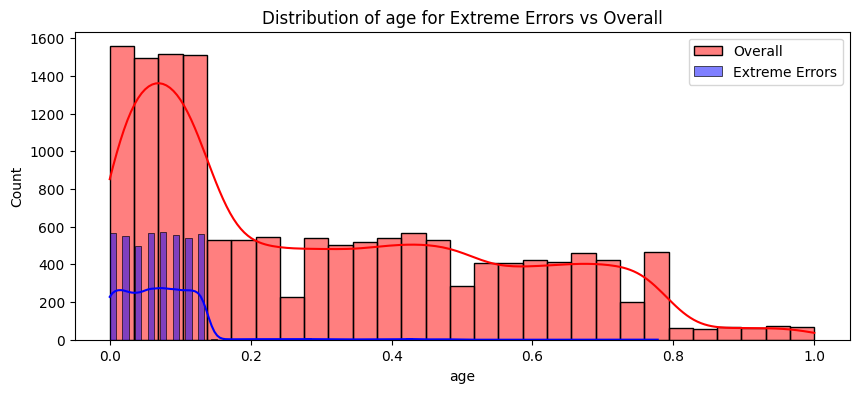

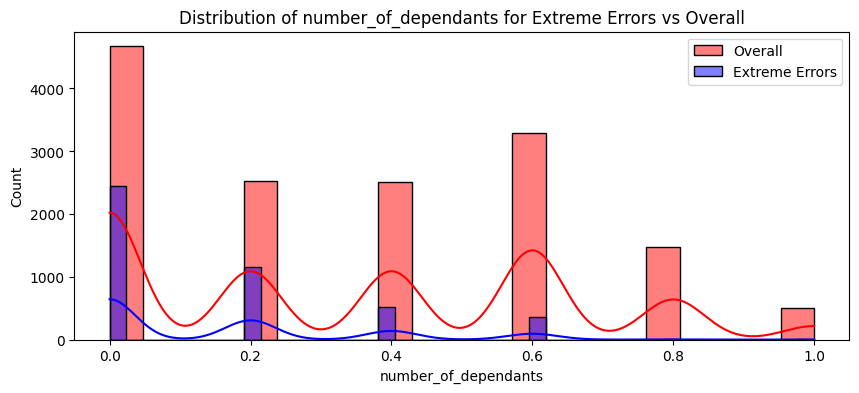

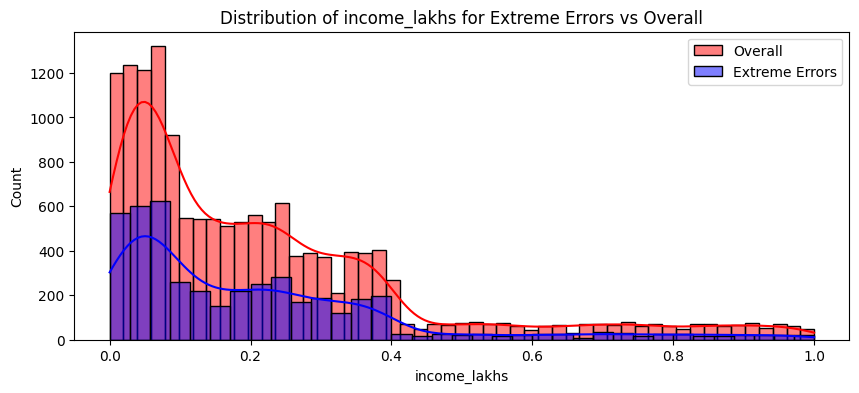

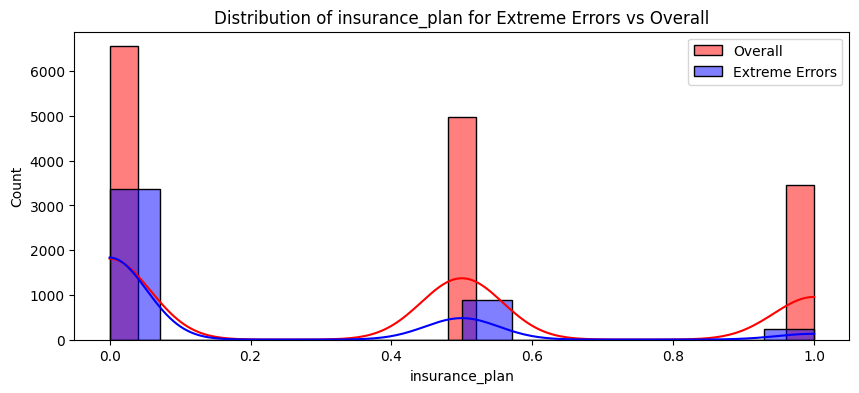

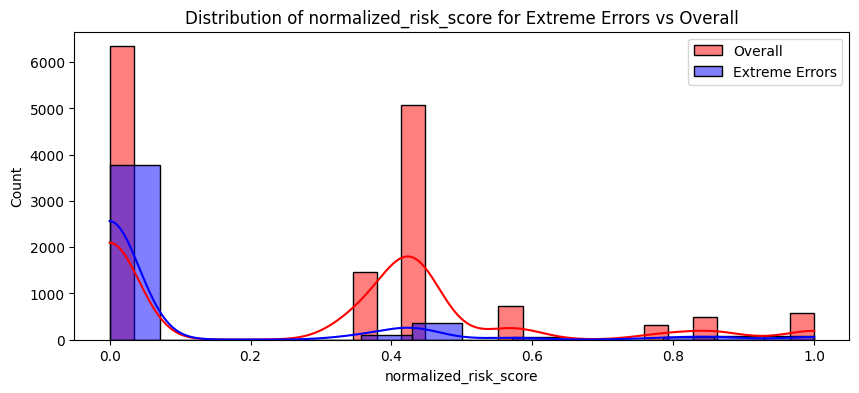

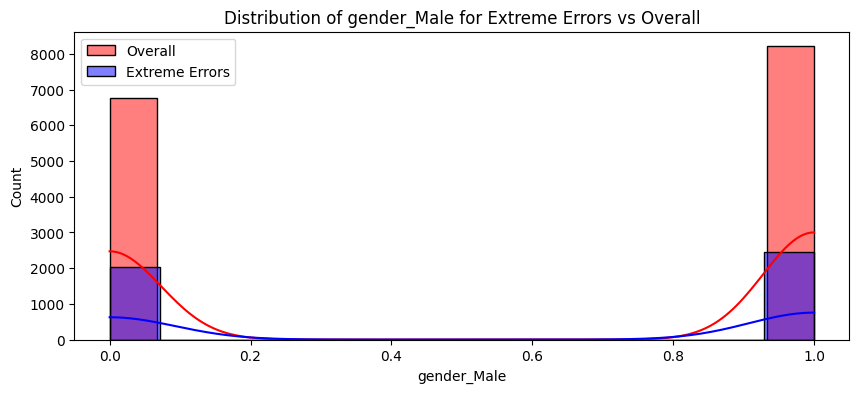

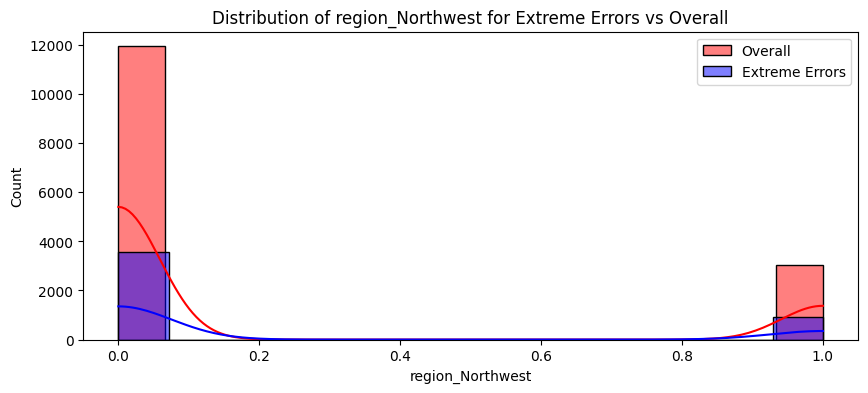

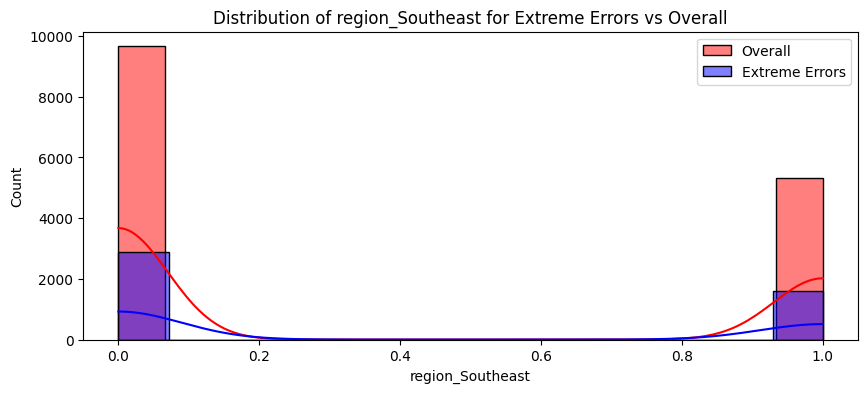

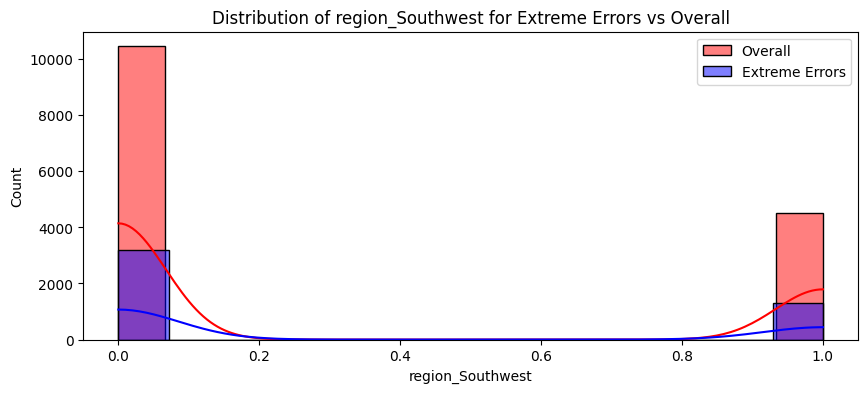

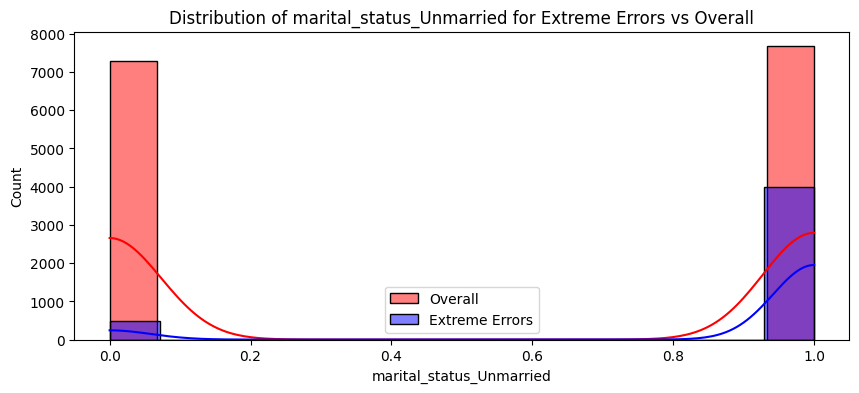

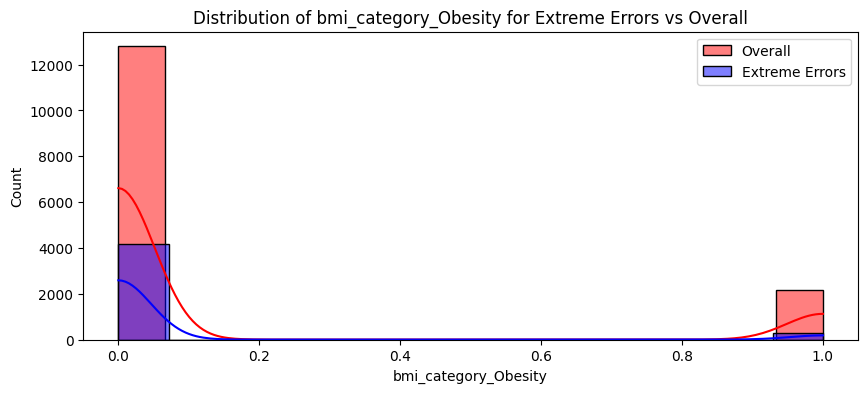

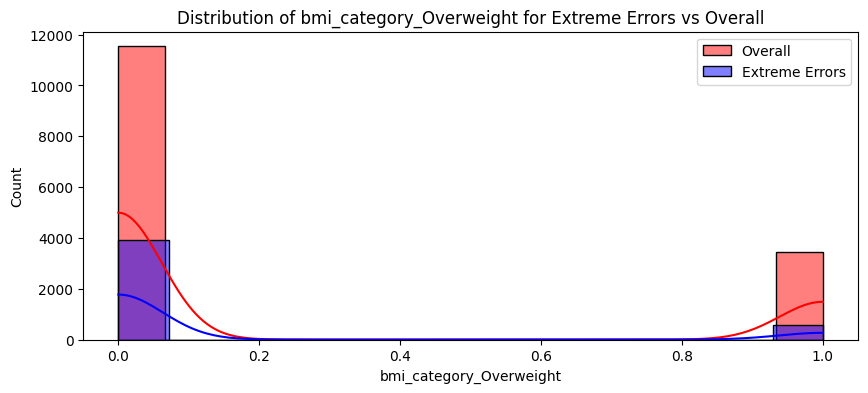

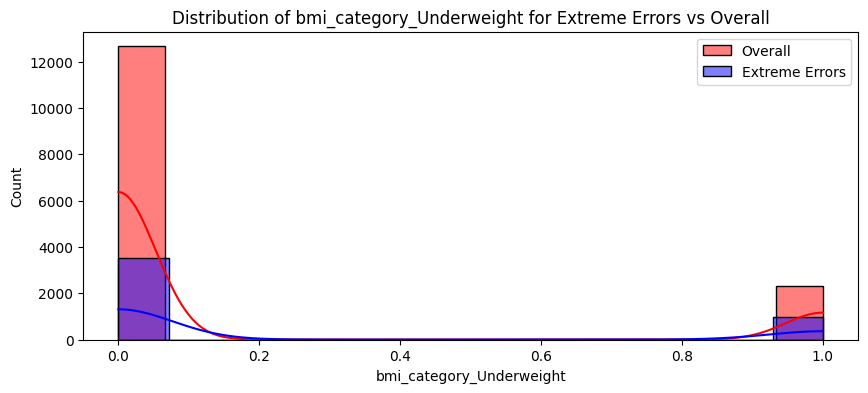

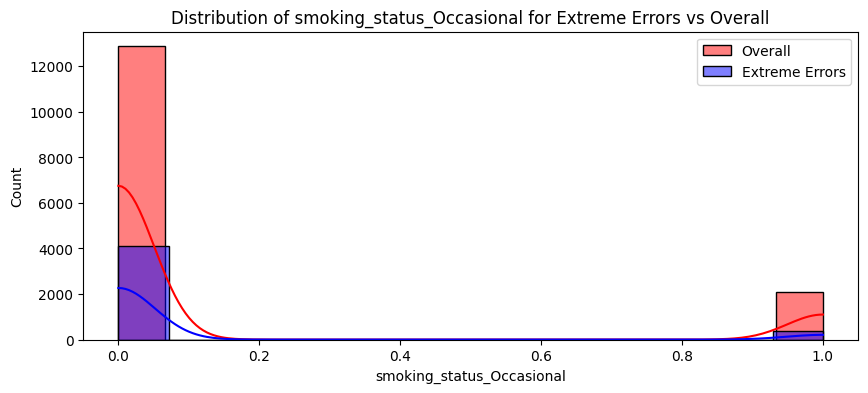

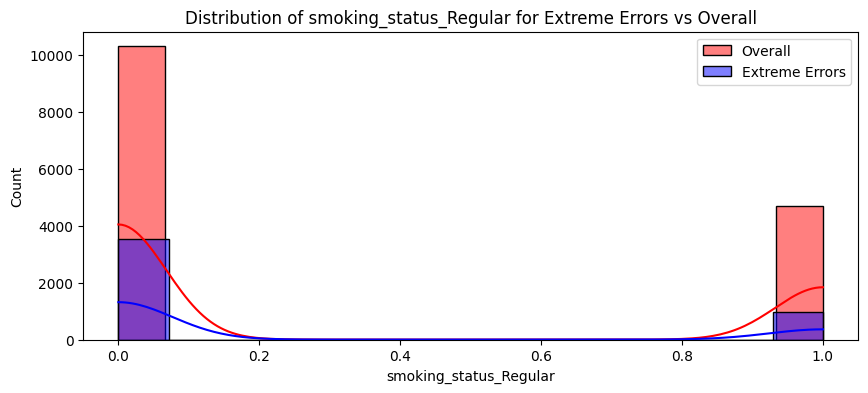

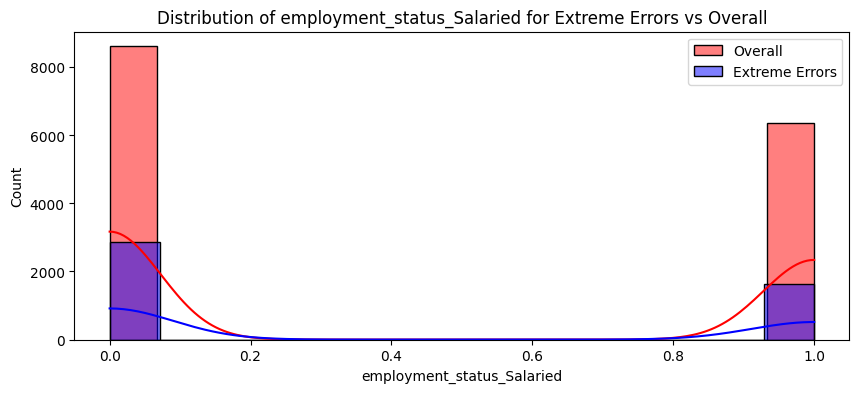

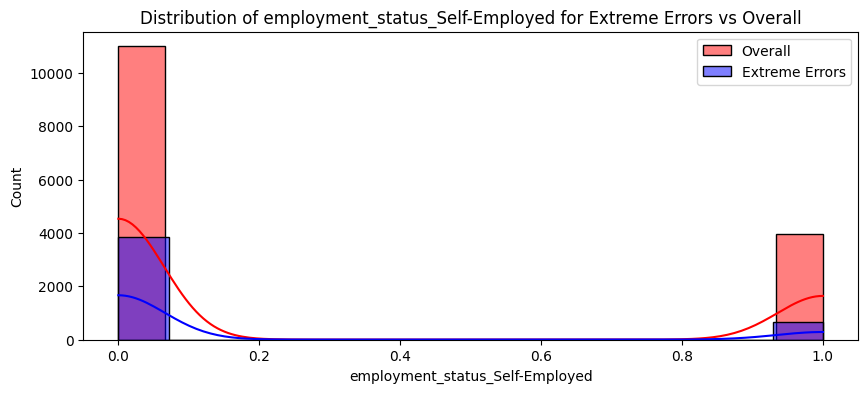

In [88]:
# Let's run all the Features in a for loop

for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(X_test[feature], label='Overall', color='red',kde=True)
    sns.histplot(extreme_errors_df[feature], color='blue', alpha=0.5,label='Extreme Errors', kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

**Inspect Age Distribution for Anomaly**

<Axes: xlabel='age', ylabel='Count'>

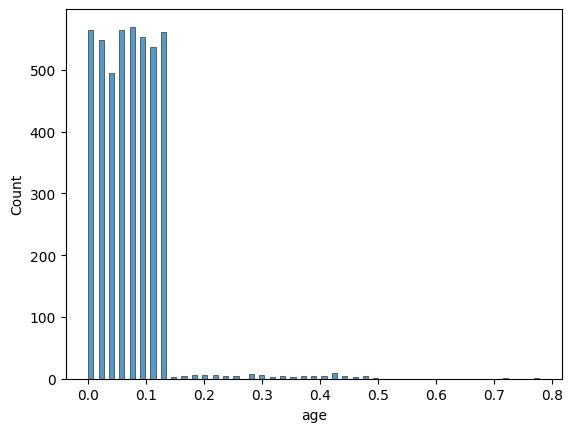

In [89]:
sns.histplot(extreme_errors_df.age)

In [93]:
extreme_errors_df.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [94]:
extreme_errors_df['income_level'] = -1

<Axes: xlabel='age', ylabel='Count'>

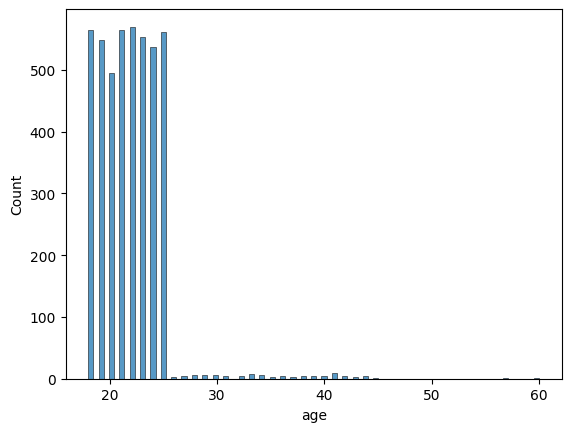

In [96]:
# Let's reverse scale for better view
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
sns.histplot(df_reversed['age'])

In [98]:
df_reversed['age'].describe()
# 75% of age group is < 24

count    4487.000000
mean       21.804992
std         3.172355
min        18.000000
25%        20.000000
50%        22.000000
75%        24.000000
max        60.000000
Name: age, dtype: float64

In [97]:
df_reversed['age'].quantile(0.97)
# 97% of the age group <25

25.0

We definitely need to do further analysis into the age data.

### **Model Segmentation**